<a href="https://colab.research.google.com/github/axissixa/ichi-no-codu/blob/master/simplify_sat_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simplify satellite data
simplify the access and analysis of satellite data from sentinel-2b using available python libraries.

## Dependencies

### Installs
Install dependencies

In [ ]:
!pip install rioxarray
!pip install sentinelsat
!pip install pystac_client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 24.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 3.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.0/154.0 kB 3.8 MB/s eta 0:00:00


###  Imports

In [ ]:
import shapely
from shapely.ops import transform
import rioxarray
from sentinelsat import SentinelAPI
from pystac_client import Client
from pyproj import Transformer

### Constants

In [ ]:
IMAGE_API = "https://earth-search.aws.element84.com/v0"
MDATA_API = "https://scihub.copernicus.eu/dhus"

LATLONG = 'EPSG:4326'

## Functions

### Query sentinel cogs

In [ ]:
def query_stac_with_coordinate(coordinates, max_items=1, time_interval=None, cloud_cover_percent=0, data_coverage_in_tile=70):
    """
    coordinates : shapely Polygon, list of coordinates for an area
    returns : stac.ItemCollection 
    """
    stac_client = Client.open(IMAGE_API)
    sentinel_data_refs = stac_client.search(
        collections=["sentinel-s2-l2a-cogs"],
        intersects=coordinates,
        datetime=time_interval,
        max_items=max_items,
        query={
            "eo:cloud_cover": {"lte": cloud_cover_percent},
            "sentinel:valid_cloud_cover" : {"eq": True},
            "sentinel:data_coverage" : {"gte":data_coverage_in_tile}
        },
        sortby=[
            {
                "field": "properties.sentinel:data_coverage",
                "direction" : "desc"
            }
        ]
    ).get_all_items()
    return sentinel_data_refs


### Query Metadata

In [ ]:
def get_metadata_for_tile(id):
    """
     id : filename of stac.Item ex. query_stac_with_coordinate(coords)[0].properties['sentinel:product_id']
     returns : dictionary of metadata items
    """
    
    mdata_api = SentinelAPI('exmachine144', 'technology5D', MDATA_API)
    mdata = mdata_api.query(
        platformname='sentinel-2',
        producttype='S2MSI2A',
        filename=f"{id}"
    )
    return dict(mdata)

### download image as xarray

In [ ]:
def download_image(image_url):
  img = rioxarray.open_rasterio(image_url)
  return img

### Crop raster image

In [ ]:
def crop_tile_to_poly(image, poly):
    """
     image: xarray/dataarray 
     poly : shapely polygon in (Latitude, longitude) format
     returns : cropped xArray object 
    """
    cropped_img = image.rio.clip_box(*poly.bounds)
    return cropped_img

### transform geometry

In [ ]:
#### Buffer a point object to a bounding box around it by deg lat longs
def point_buffer_polygon(point, buffer_deg=0.3):
    return shapely.box(point.buffer(distance=buffer_deg, quad_segs=1).bounds)
    
#### Transform shapely geometry betweem CRSs
def shapely_geo_coordinate_transformation(geometry, source, target):
    t = Transformer.from_crs(source, target, always_xy=True).transform
    return transform(t, geometry)

def point_to_sqbox(center, target, side=1000, source=LATLONG):
    transformed_center = shapely_geo_coordinate_transformation(center, source, target)
    poly = transformed_center.buffer(side)
    return poly

## Shapely geometry manipulation
trying to use multipolygon class and intersections

### polygon set 1

In [ ]:
A = shapely.Point(10,10).buffer(2)
B = shapely.Point(15,15).buffer(2)
C = shapely.Point(20,20).buffer(2)
polyset1 = shapely.MultiPolygon([A,B,C])

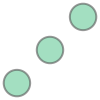

In [ ]:
polyset1

### polygon set 2

In [ ]:
I = shapely.Point(10,15).buffer(5)
K = shapely.Point(10,9).buffer(1)
J = shapely.Point(18,20).buffer(2)
polyset2 = shapely.MultiPolygon([I,J, K])

### superset

In [ ]:
polysuperset = shapely.MultiPolygon([A,B,C, I, J, K])

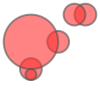

In [ ]:
polysuperset

### intersection

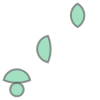

In [ ]:
polyset1.intersection(polyset2)

## Run

In [ ]:
coords = [14.3521, 77.590082]
band = 'visual'
p = shapely.Point(coords[1], coords[0])

In [ ]:
cog_url_dict = query_stac_with_coordinate(p).items[0].assets

In [ ]:
img = download_image(cog_url_dict[band].href)

In [ ]:
img.rio.bounds()

(699960.0, 1490220.0, 809760.0, 1600020.0)

In [ ]:
pp_box = point_to_sqbox(p, img.rio.crs, 2000)
l = point_to_sqbox(p, img.rio.crs, 100)

In [ ]:
cropped_img = crop_tile_to_poly(img, pp_box)

In [ ]:
cropped_img.rio.to_raster("test.jpg")

In [ ]:
import matplotlib.pyplot as plt

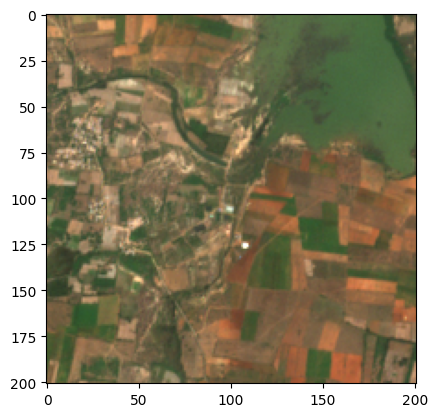

In [ ]:
plt.imshow(cropped_img.transpose('y','x','band'))